<a href="https://colab.research.google.com/github/LiadTssf/cloud-project/blob/main/hw2/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import requests
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
# Function to fetch and parse a webpage
def fetch_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup  # This is the parsed content of the webpage
    else:
        return None


# Function to create a word frequency dictionary from the parsed content
def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index  # This dictionary represents the word counts in the page


# Function to remove stop words from the word frequency dictionary
def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index



# Function to apply stemming to the words in the word frequency dictionary
def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index



# Function to calculate term frequency (TF)
def calculate_tf(word_counts):
    tf_dict = {}
    total_terms = sum(word_counts.values())
    for word, count in word_counts.items():
        tf_dict[word] = count / total_terms
    return tf_dict



# Function to search using TF-IDF
def search(query, tf_idf):
    stemmer = PorterStemmer()
    query_words = re.findall(r'\w+', query.lower())
    results = {}
    for word in query_words:
        word = stemmer.stem(word)
        if word in tf_idf:
            results[word] = tf_idf[word]
    return results


# Function to calculate inverse document frequency (IDF)
def calculate_idf(documents):
    idf_dict = {}
    total_docs = len(documents)
    for doc in documents:
        for word in doc.keys():
            if word in idf_dict:
                idf_dict[word] += 1
            else:
                idf_dict[word] = 1
    for word, count in idf_dict.items():
        idf_dict[word] = math.log(total_docs / float(count))
    return idf_dict

# Function to calculate TF-IDF
def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, tf_value in tf.items():
        tf_idf[word] = tf_value * idf.get(word, 0)
    return tf_idf

# Function to fetch and index multiple documents
def fetch_and_index_documents(urls):
    documents = []
    for url in urls:
        soup = fetch_page(url)
        if soup is not None:
            index = index_words(soup)
            index = remove_stop_words(index)
            index = apply_stemming(index)
            documents.append(index)
    return documents

# Function to perform search engine operations
def search_engine_tf_idf(url, query, documents):
    soup = fetch_page(url)  # Fetch and parse the webpage
    if soup is None:
        return None
    index = index_words(soup)  # Create word frequency dictionary
    index = remove_stop_words(index)  # Remove stop words
    index = apply_stemming(index)  # Apply stemming

    # Calculate TF for the current document
    tf = calculate_tf(index)

    # Calculate IDF for the entire corpus
    idf = calculate_idf(documents)

    # Calculate TF-IDF for the current document
    tf_idf = calculate_tf_idf(tf, idf)

    # Perform search using TF-IDF
    results = search(query, tf_idf)
    return results

# List of URLs to include in your corpus for IDF calculation
urls = [
    'https://w3.braude.ac.il/?lang=en'
]

# Fetch and index all documents in the corpus
documents = fetch_and_index_documents(urls)

# Search in a specific page
search_url = 'https://w3.braude.ac.il/?lang=en'
query = 'industry'
results = search_engine_tf_idf(search_url, query, documents)
print(results)


In [ ]:
import requests
from bs4 import BeautifulSoup
from collections import Counter

# Fetch the webpage content
url = 'https://cad.onshape.com/help/Content/Glossary/glossary.htm?tocpath=_____19'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract text and count occurrences of each word
text = soup.get_text()
words = text.split()
word_counts = Counter(words)

# Select the 10 most significant words
significant_words = ['assembly', 'drawing', 'feature', 'mate', 'part', 'sketch', 'extrude', 'dimension', 'constraint', 'surface']
significant_counts = {word: word_counts[word] for word in significant_words}

print(significant_counts)

{'assembly': 16, 'drawing': 28, 'feature': 39, 'mate': 22, 'part': 86, 'sketch': 64, 'extrude': 0, 'dimension': 25, 'constraint': 3, 'surface': 30}


In [4]:
!pip install firebase-admin
!pip install firebase

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Glossary index stored successfully in Firebase
Team data stored successfully in Firebase


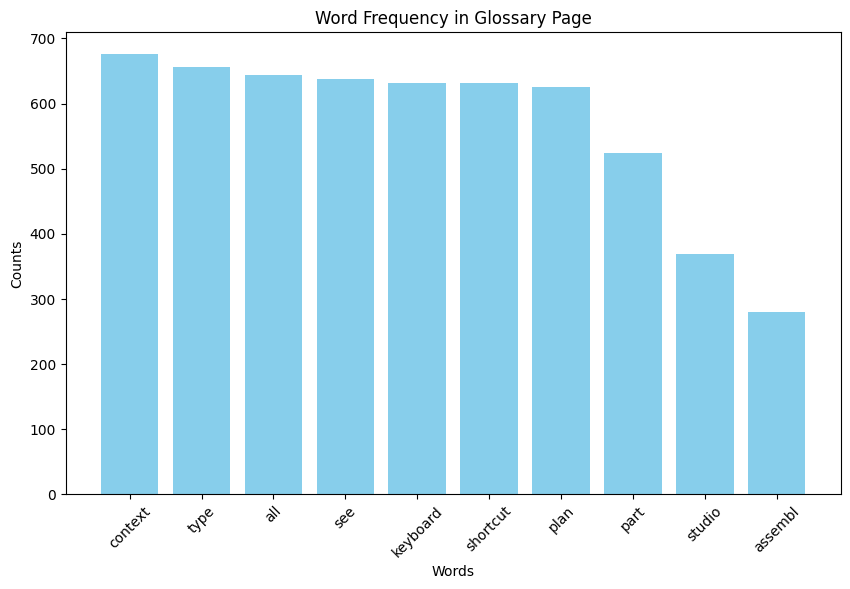

In [23]:
import requests
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
from collections import Counter
import firebase_admin
from firebase_admin import credentials, db
import matplotlib.pyplot as plt
from firebase import firebase
import json
import pandas as pd


def fetch_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        return None

def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to','also','of','n'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count

    return stemmed_index
"""
def search(query, index):

    stemmer = PorterStemmer()
    query_words = re.findall(r'\w+', query.lower())
    print(query)
    results = {}
    for word in query_words:
        word = stemmer.stem(word)
        if word in index:
            results[word] = index[word]
    return results
"""
def search_engine(url):
    soup = fetch_page(url)
    if soup is None:
        return None
    index = index_words(soup)
    index = remove_stop_words(index)
    index = apply_stemming(index)
    #results = search(query, index)
    return index
'''
# Fetch and process the Onshape glossary
url = 'https://cad.onshape.com/help/Content/Glossary/glossary.htm?tocpath=_____19'
index = search_engine(url)

# Select the top 10 most significant words
most_common_words = Counter(index).most_common(10)
print("most_common_words" ,most_common_words)
significant_counts = dict(most_common_words)


print("transformed_data",transformed_data)

# Initialize Firebase using your method
FBconn = firebase.FirebaseApplication('https://test100000-ccdb4-default-rtdb.asia-southeast1.firebasedatabase.app/', None)

# Store the word counts in Firebase
result = FBconn.put('/glossary', 'words', transformed_data)
print("Data stored successfully in Firebase:", result)
'''
def save_glossary_index_to_firebase():
    url = 'https://cad.onshape.com/help/Content/Glossary/glossary.htm?tocpath=_____19'
    index = search_engine(url)
    significant_words = [{'term': word, 'freq': freq} for word, freq in index.items()]
    # Transform the dictionary into a list of dictionaries with term and freq
    transformed_data = [{'term': term, 'freq': freq} for term, freq in significant_counts.items()]
    # Retrieve the data
    FBconn.put('/glossary', 'index', transformed_data)
    print("Glossary index stored successfully in Firebase")

# Save JSON data to Firebase
def save_json_to_firebase(file_path):
    with open(file_path, 'r') as file:
        team_data = json.load(file)
    FBconn.put('/team_data', 'data', team_data)
    print("Team data stored successfully in Firebase")


file_path = '/content/drive/MyDrive/Colab Notebooks/teamA.json_label.json'

'''
# Convert to DataFrame
df = pd.DataFrame(data)

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])
'''

save_glossary_index_to_firebase()
save_json_to_firebase(file_path)

# Data from Firebase
words = [item['term'] for item in data]
counts = [item['freq'] for item in data]

# Save glossary index to Firebase

"""
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Frequency in Glossary Page')
plt.xticks(rotation=45)
plt.show()
"""

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Frequency in Glossary Page')
plt.xticks(rotation=45)
plt.show()
